In [1]:
import environment
from environment import Environment

from itertools import count
from multiprocessing import Process, Lock

import time
import random
import os, sys
import warnings
import importlib
warnings.filterwarnings("ignore", category=DeprecationWarning)

import torch
import numpy as np

In [5]:
torch.cuda.is_available()

True

In [7]:
atest=np.array([1.,3.4,5])

In [12]:
print(np.float32(atest).dtype)

float32


In [29]:
torch.backends.mps.is_built()

True

In [2]:
importlib.reload(environment)
from environment import Environment

class Schelling(Environment):
    def __init__(self, size, p_hunter = 0.05, p_prey = 0,
            prey_reward = 1, stuck_penalty = 1,
            death_penalty = 1, p_resurrection = 0.2,
            agent_max_age = 100, agent_range = 2, num_actions = 5,
            same = True, lock = None,
            max_iteration = 5000, name = None, eating_bonus = 1,
            alpha=1., beta=1., gamma = 1.):

        super(Schelling, self).__init__(size, p_hunter, p_prey,
                prey_reward = prey_reward, stuck_penalty = stuck_penalty,
                death_penalty = death_penalty, p_resurrection = p_resurrection,
                agent_max_age = agent_max_age, agent_range = agent_range, num_actions = num_actions,
                same = same, lock = lock, name = name, max_iteration = max_iteration)

        self.eating_bonus = prey_reward

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.alive_reward = 0.1
        self.geo_reward=1
    def geometric(self, agent):
        (i,j)=agent.get_loc()
        if i**2+j**2<10**2:
            return self.geo_reward
        else:
            return 0

    def default(self, agent):
        curr = self.get_agent_state(agent)
        prev = agent.get_state()
        default = (agent.get_type() * (curr - prev))
        sames = default[default > 0.1].sum()
        diffs = self.alpha * default[default < -0.1].sum()
        return sames + diffs

    def on_free(self, agent):
        self.move(agent)
        return self.beta * self.alive_reward + self.default(agent)

    def on_opponent(self, agent, opponent):
        _ = self.kill(opponent, killer=agent)
        return self.beta * self.alive_reward + self.default(agent) + self.prey_reward * self.gamma

    def on_still(self, agent):
        return -10*self.alive_reward

    def on_obstacle(self, agent):
        return -10*self.alive_reward
    def on_same(self, agent, other):
        return -10*self.alive_reward

    def kill(self, victim, killer=False):
        if victim.get_type() in [-1, 1]:
            id = victim.get_id()
            if id in self.id_to_type:
                self.id_to_lives[id].append(victim.get_age())
            else:
                self.id_to_type[id] = victim.get_type()
                self.id_to_lives[id] = [victim.get_age()]
        i, j = victim.get_loc()

        self.map[i, j] = 0
        state = self.get_agent_state(victim)
        del self.loc_to_agent[(i, j)]

        victim.die(state, -self.death_penalty)
        if killer:
            killer.eat(self.gamma * 1)
            self.move(killer)
        return -self.death_penalty

def play(map, episodes, iterations, eps=1e-6):
    # map.configure(prey_reward, stuck_penalty, agent_max_age)
    agents = map.get_agents()
    directions = [(-1, 0), (0, -1), (1, 0), (0, 1), (0, 0)]
    times = 0
    for episode in range(episodes):
        c = 0
        for t in count():
            t_start = time.time()
            state = map.get_map()
            random.shuffle(agents)

            keys = ["A", "B", "prey"]
            rews = {key: 0 for key in keys}
            counts = {key: 0 for key in keys}
            for agent in agents:
                towards = None
                name = map.vals_to_names[agent.get_type()]
                if agent.is_alive():
                    agent_state = agent.get_state()
                    action = agent.decide(agent_state)
                    towards = directions[action]
                rew = map.step(agent, towards)
                rews[name] += rew
                counts[name] += 1

            map.update()

            map.record(rews)

            next_state = map.get_map()

            time_elapsed = time.time() - t_start
            times += time_elapsed
            avg_time = times / (t + 1)
            print("I: %d\tTime Elapsed: %.2f" % (t+1, avg_time), end='\r')
            if abs(next_state - state).sum() < eps:
                c += 1

            if t == (iterations - 1) or c == 20:
                break

            state = next_state
        map.save(episode)
    print("SIMULATION IS FINISHED.")

In [3]:
agent_range=5
prey_reward=75
name="test4"
max_age=100
iterations=10
alpha=1
beta=1
gamma=1
l=Lock()
society=Schelling


In [4]:
play(society((50, 50), agent_range = int(agent_range),
        prey_reward = int(prey_reward), name=name,
        agent_max_age = int(max_age), max_iteration = int(iterations),
        lock=l, alpha=float(alpha), beta=float(beta), gamma=float(gamma)),1,1000)

d:\CloudData\iCloudDrive\PhD\lecture\Complex Social System\segregation\segregation\mind.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  state = torch.tensor([[state]], device=self.device, dtype=torch.float32)


In [16]:
society.get_agents

<function environment.Environment.get_agents(self)>

In [34]:
import numpy as np
import gzip

with gzip.GzipFile('my_experiment/crystal.npy.gz', "r") as f:
    crystal = np.load(f)

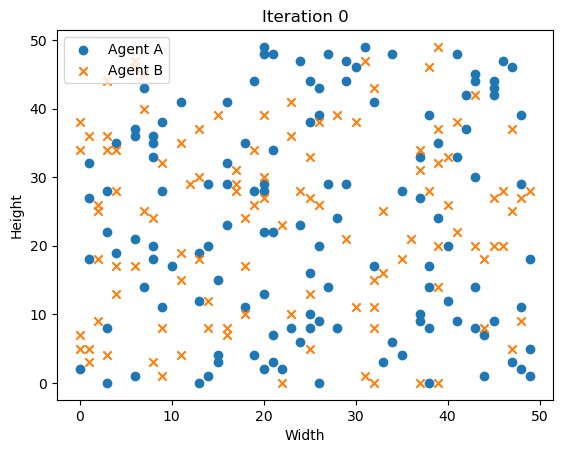

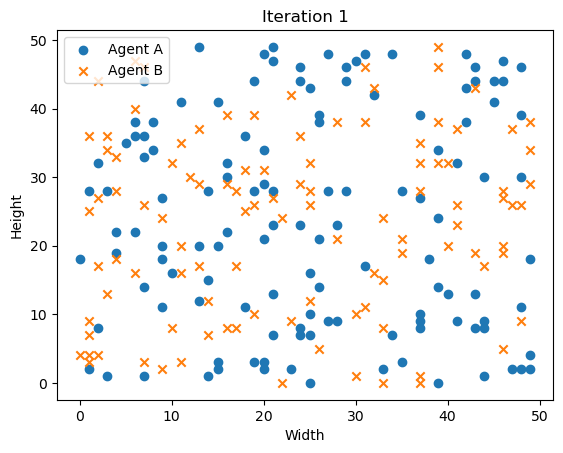

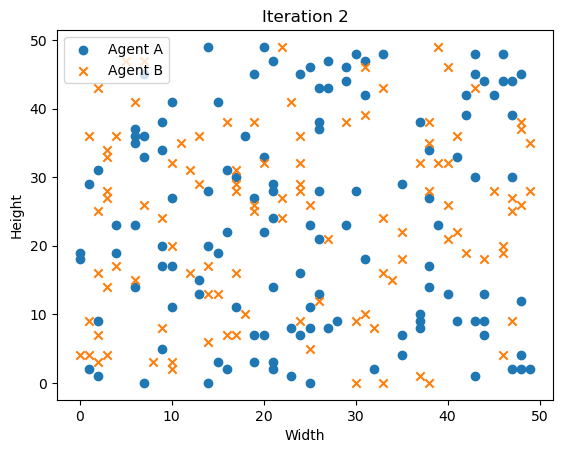

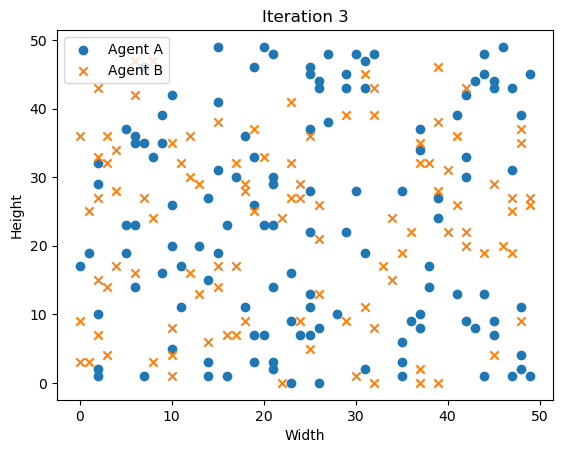

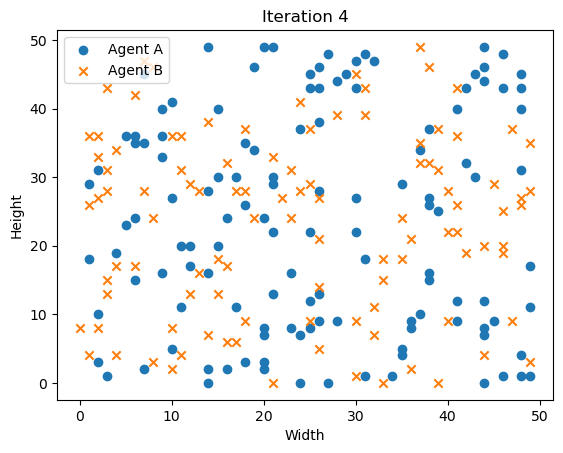

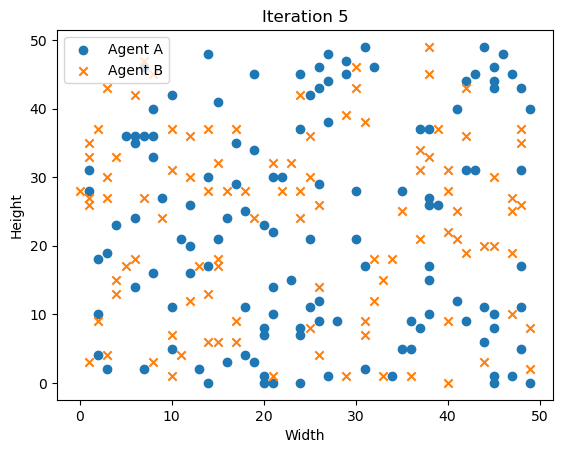

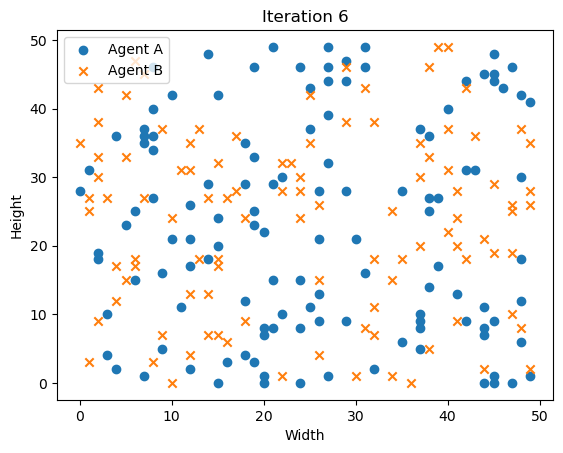

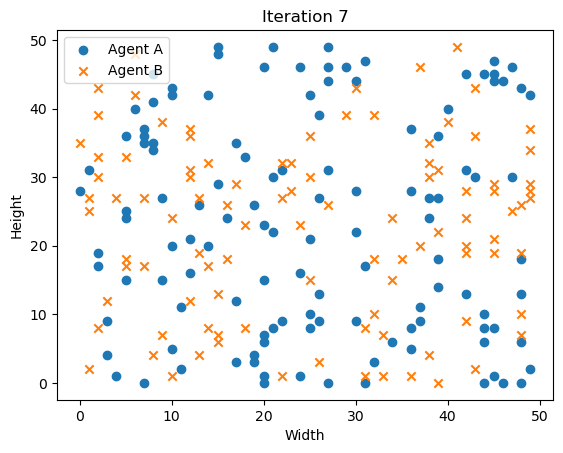

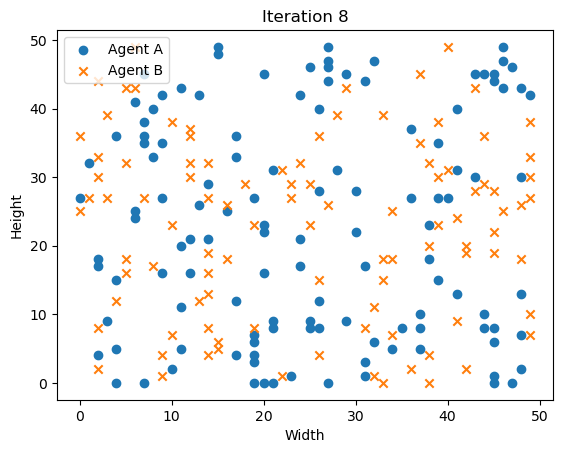

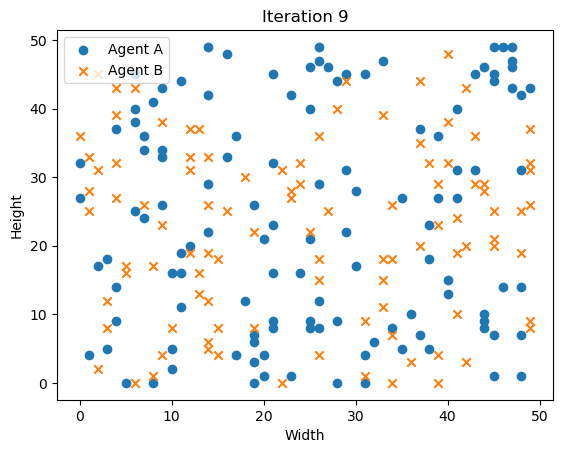

In [32]:
import matplotlib.pyplot as plt

agent_A_positions = []
agent_B_positions = []

for t in range(crystal.shape[0]):  # Iterate over each iteration
    positions_A = np.argwhere(crystal[t, :, :, 0] == -1)  # Find A positions
    positions_B = np.argwhere(crystal[t, :, :, 0] == 1)   # Find B positions
    
    agent_A_positions.append(positions_A)
    agent_B_positions.append(positions_B)

# Example visualization: plot positions of agents A and B over iterations
for t, (pos_A, pos_B) in enumerate(zip(agent_A_positions, agent_B_positions)):
    plt.figure()
    if pos_A.size > 0:
        plt.scatter(pos_A[:, 1], pos_A[:, 0], label='Agent A', marker='o')
    if pos_B.size > 0:
        plt.scatter(pos_B[:, 1], pos_B[:, 0], label='Agent B', marker='x')
    plt.title(f"Iteration {t}")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.legend()
    plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import gzip

# Load the data
with gzip.GzipFile('my_experiment/crystal.npy.gz', "r") as f:
    crystal = np.load(f)

# Prepare lists to store frames for the GIF
frames = []

for t in range(crystal.shape[0]):  # Iterate over each iteration
    fig, ax = plt.subplots()
    ax.set_title(f"Iteration {t}")
    ax.set_xlabel("Width")
    ax.set_ylabel("Height")

    # Find positions for A and B
    positions_A = np.argwhere(crystal[t, :, :, 0] == -1)  # Type -1 for A
    positions_B = np.argwhere(crystal[t, :, :, 0] == 1)   # Type 1 for B

    # Plot positions of A and B
    if positions_A.size > 0:
        ax.scatter(positions_A[:, 1], positions_A[:, 0], label='Agent A', marker='o', color='blue')
    if positions_B.size > 0:
        ax.scatter(positions_B[:, 1], positions_B[:, 0], label='Agent B', marker='o', color='orangered')
    
    ax.legend()

    # Save the frame as an image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    plt.close(fig)  # Close the figure to save memory

# Save frames as a GIF
imageio.mimsave('agent_positions.gif', frames, fps=10)